In [1]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
import scanpy as sc


In [7]:
import utils
from config import store_dir, data_dir, date_key
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [3]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )

In [4]:
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )

In [5]:
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [34]:
mdt['top_Organism'] = utils.top_feature_col(mdt['Organism'])
mdt['top_Condition'] = utils.top_feature_col(mdt['Condition'])
mdt['top_Organism_Part'] = utils.top_feature_col(mdt['Organism_Part'])
mdt['top_Polarity'] = utils.top_feature_col(mdt['Polarity'])
mdt['top_maldi_matrix'] = utils.top_feature_col(mdt['maldi_matrix'], top=8)
mdt['top_Group'] = utils.top_feature_col(mdt['Group'])

# Make table with all features and create AnnData object

Make feature list/table 

In [10]:
fdr_cutoff = 0.5

In [11]:
# Get all features

features = []
for tab in tqdm(results.values()):
    tmp_tab = tab[tab['fdr'] <= 0.5]
    for ix in tmp_tab['ion']:
            features.append(ix)
features = list(set(features))

100%|██████████| 7443/7443 [00:10<00:00, 688.22it/s] 


In [12]:
len(features)

77087

In [13]:
# Initialize empty df
fdr_data = pd.DataFrame(0, columns=list(set(features)), index=results.keys(), dtype='float64')

In [14]:
fdr_data.shape

(7443, 77087)

In [15]:
# Fill dataframe
for i in tqdm(results.keys()):
    # It is late, I lost my creativity for variable names
    tmp_tab = results[i][results[i]['fdr'] <= 0.5]
    
    ttt = tmp_tab.reset_index()[['ion', 'intensity']]
    ttt2 = ttt.groupby('ion').sum()
    
    fdr_data.loc[i, ttt2.index] = ttt2['intensity'].values

100%|██████████| 7443/7443 [01:52<00:00, 65.97it/s]


In [16]:
adata = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])

/tmp/ipykernel_957/3986562972.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [17]:
adata

AnnData object with n_obs × n_vars = 7443 × 77087
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group'
    var: 0

# Analysis

## All data

In [53]:
sc.pp.filter_genes(adata, min_cells=200)
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.normalize_total(adata, target_sum=1e4)


In [54]:
adata

AnnData object with n_obs × n_vars = 6504 × 9437
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes'
    var: 0, 'n_cells'

In [55]:
sc.pp.neighbors(adata, metric='cosine')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
sc.tl.umap(adata)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


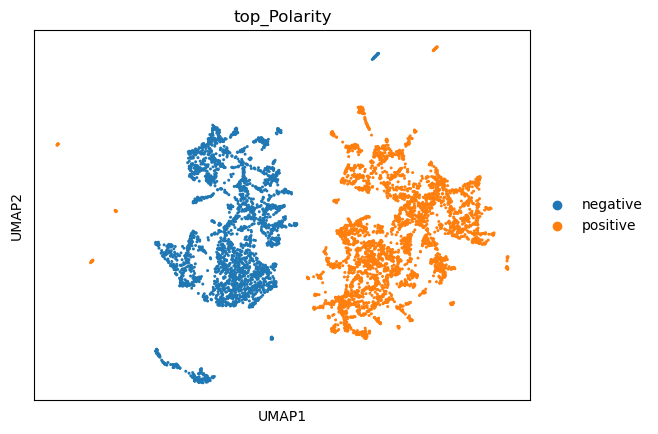

In [57]:
sc.pl.umap(adata, color='top_Polarity')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


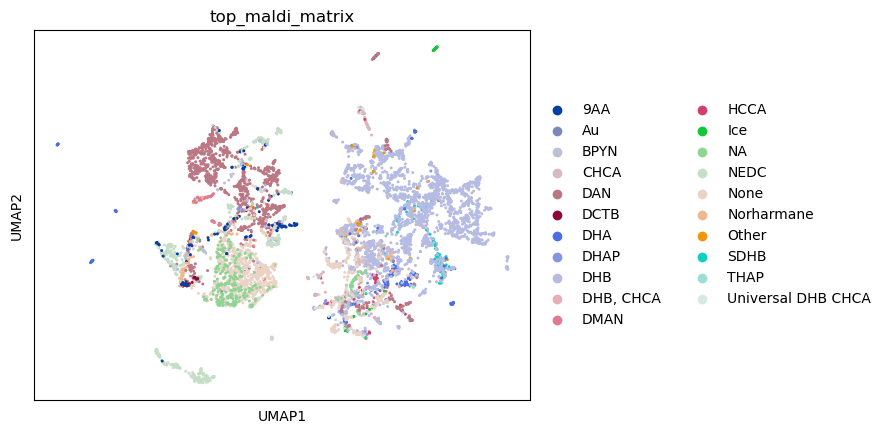

In [58]:
sc.pl.umap(adata, color='top_maldi_matrix')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


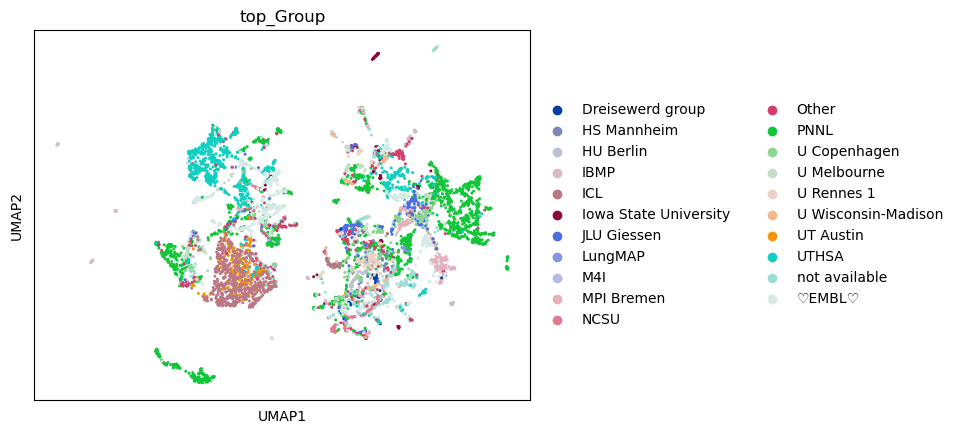

In [59]:
sc.pl.umap(adata, color='top_Group')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


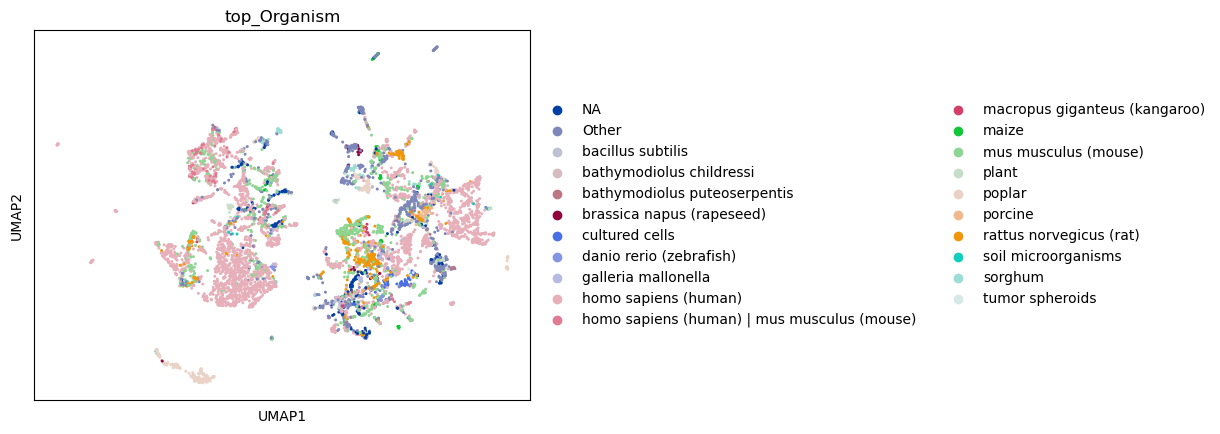

In [60]:
sc.pl.umap(adata, color='top_Organism')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


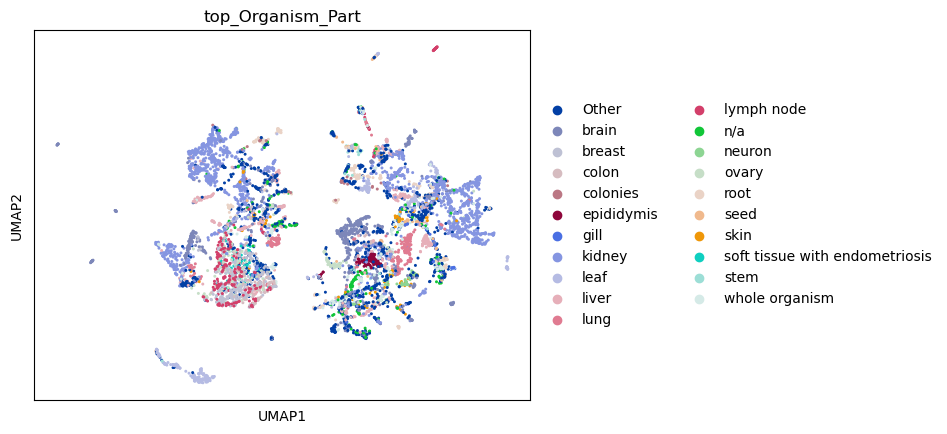

In [61]:
sc.pl.umap(adata, color='top_Organism_Part')

## Positive

# Continue here:

* Separate polarities
* Play with batch correction

In [62]:
adata2 = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])

/tmp/ipykernel_111/3552823750.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata2 = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [71]:
adata_pos = adata2[adata2.obs['Polarity']=='positive',:]

In [73]:
sc.pp.filter_genes(adata_pos, min_cells=200)
sc.pp.filter_cells(adata_pos, min_genes=50)
sc.pp.normalize_total(adata_pos, target_sum=1e4)
sc.pp.neighbors(adata_pos, metric='cosine')
sc.tl.umap(adata_pos)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


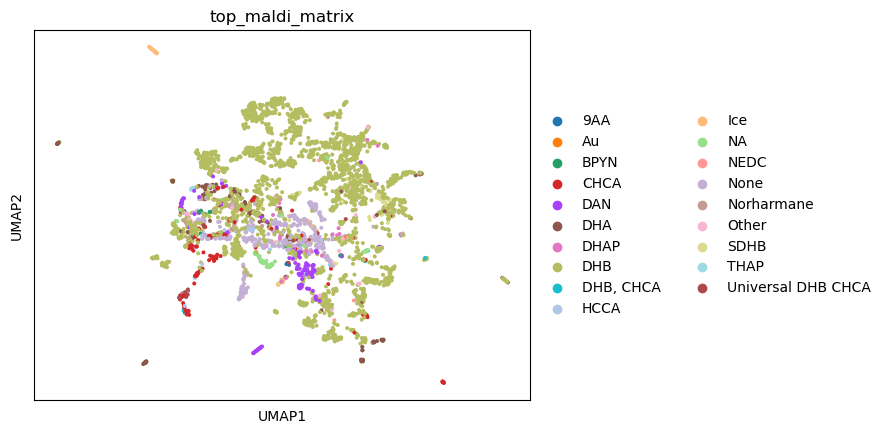

In [74]:
sc.pl.umap(adata_pos, color='top_maldi_matrix')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


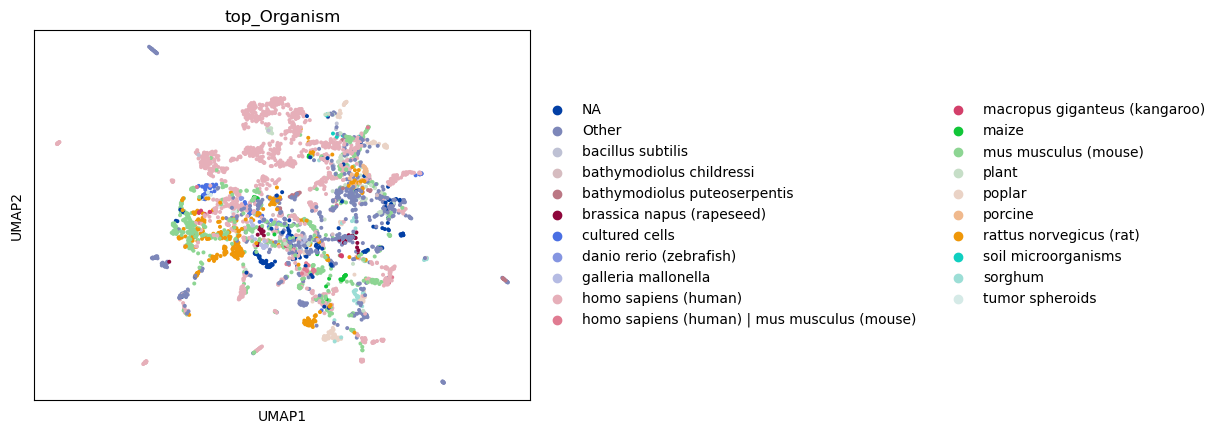

In [75]:
sc.pl.umap(adata_pos, color='top_Organism')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


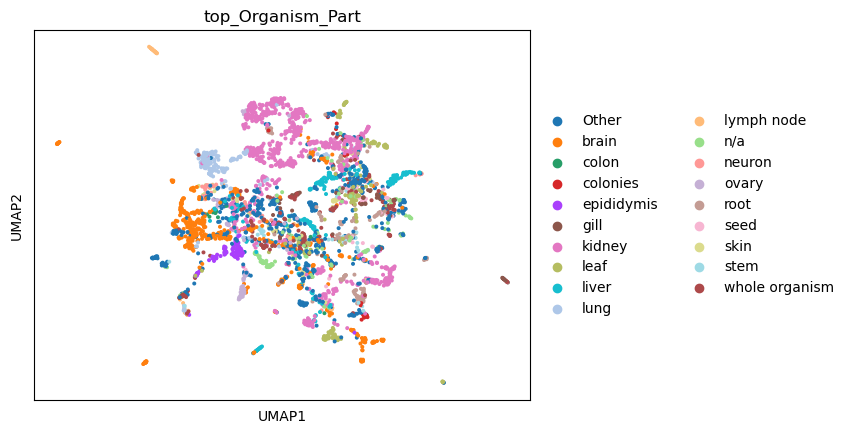

In [76]:
sc.pl.umap(adata_pos, color='top_Organism_Part')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


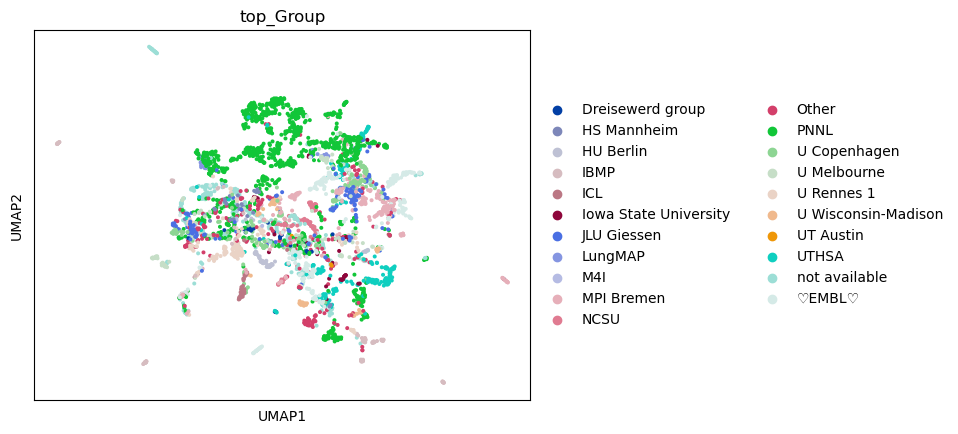

In [78]:
sc.pl.umap(adata_pos, color='top_Group')

## Negative

In [35]:
adata2 = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])
adata_neg = adata2[adata2.obs['Polarity']=='negative',:]

/tmp/ipykernel_957/706496766.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata2 = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [36]:
adata_neg

View of AnnData object with n_obs × n_vars = 3141 × 77087
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group'
    var: 0

In [20]:
sc.pp.filter_genes(adata_neg, min_cells=200)
sc.pp.filter_cells(adata_neg, min_genes=50)
sc.pp.normalize_total(adata_neg, target_sum=1e4)
sc.pp.neighbors(adata_neg, metric='cosine')
sc.tl.umap(adata_neg)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


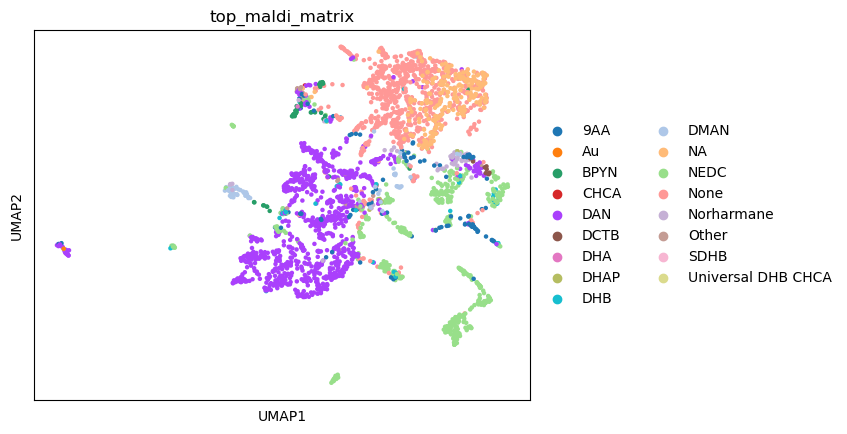

In [21]:
sc.pl.umap(adata_neg, color='top_maldi_matrix')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


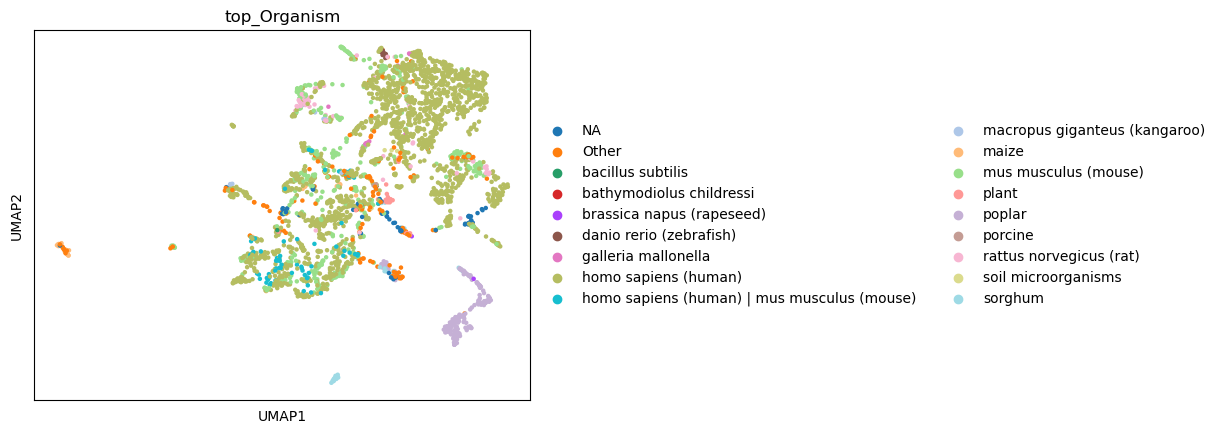

In [22]:
sc.pl.umap(adata_neg, color='top_Organism')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


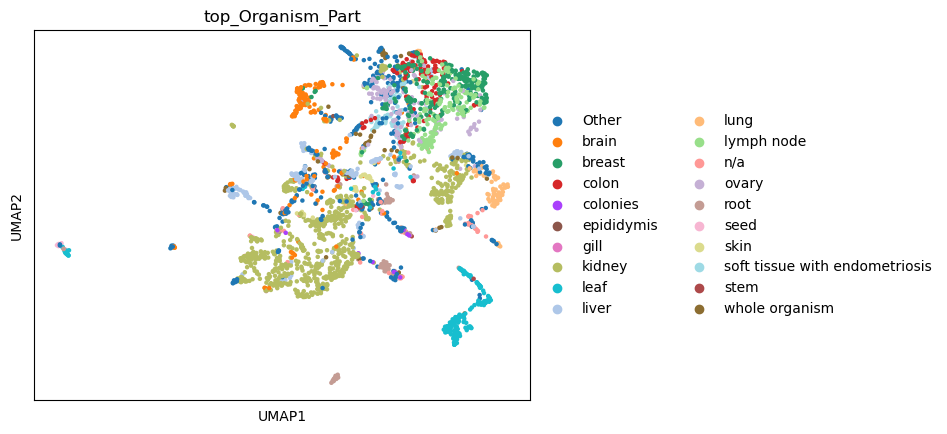

In [23]:
sc.pl.umap(adata_neg, color='top_Organism_Part')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


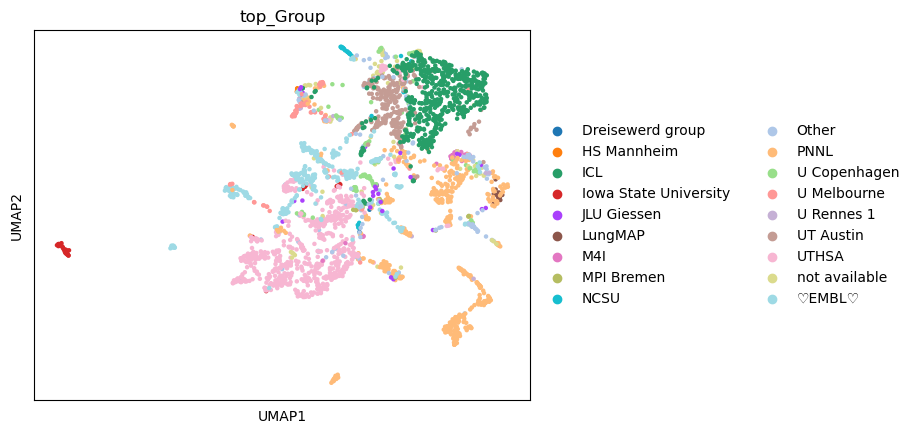

In [24]:
sc.pl.umap(adata_neg, color='top_Group')

### BBKNN

In [37]:
pd.value_counts(adata_neg.obs.top_maldi_matrix)

DAN      1059
None      819
NEDC      528
Other     264
NA        210
9AA       178
DHB        71
CHCA       10
DHA         2
Name: top_maldi_matrix, dtype: int64

In [39]:
adata_neg_2=adata_neg[adata_neg.obs['top_maldi_matrix']!='Other', :]

In [44]:
sc.pp.filter_genes(adata_neg_2, min_cells=200)
sc.pp.filter_cells(adata_neg_2, min_genes=50)
sc.pp.normalize_total(adata_neg_2, target_sum=1e4)
sc.pp.neighbors(adata_neg_2, metric='cosine')
sc.tl.umap(adata_neg_2)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


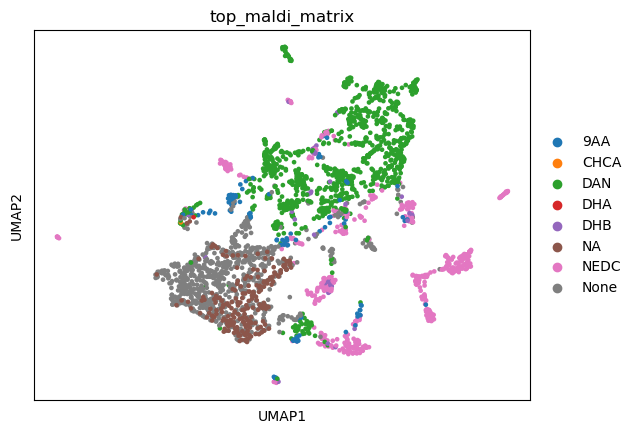

In [45]:
sc.pl.umap(adata_neg_2, color='top_maldi_matrix')

In [48]:
sc.external.pp.bbknn(adata_neg_2, batch_key='maldi_matrix', metric='cosine', neighbors_within_batch=1)

In [49]:
sc.tl.umap(adata_neg_2)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


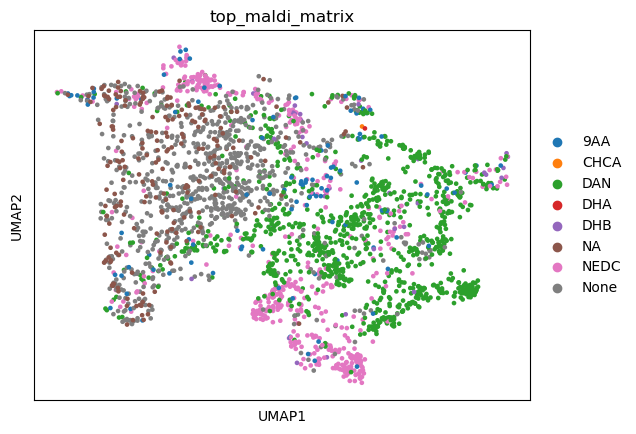

In [50]:
sc.pl.umap(adata_neg_2, color='top_maldi_matrix')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


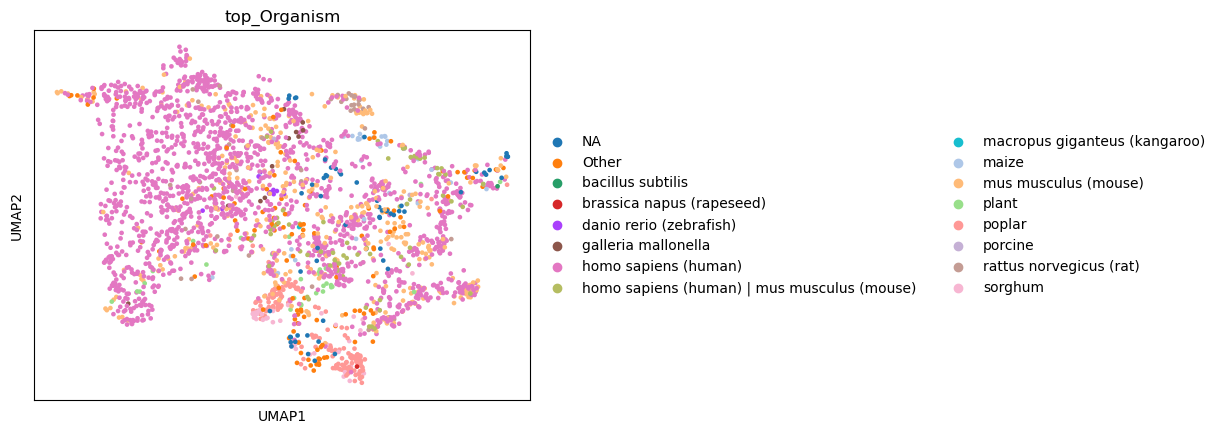

In [51]:
sc.pl.umap(adata_neg_2, color='top_Organism')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


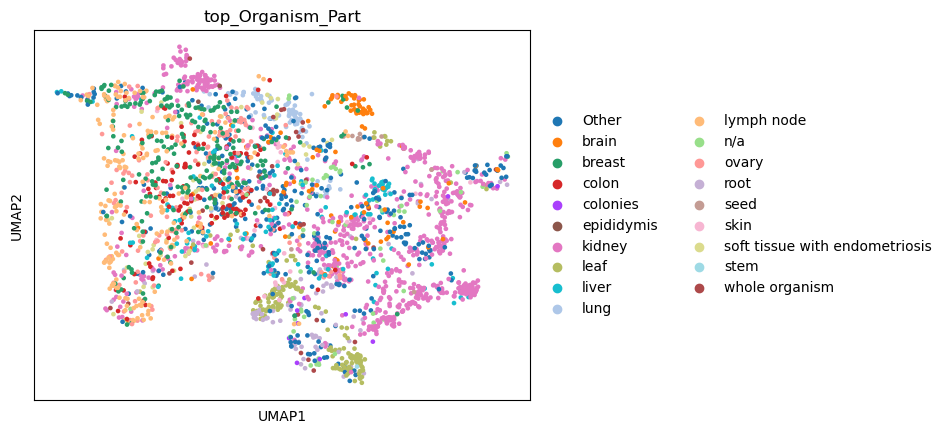

In [52]:
sc.pl.umap(adata_neg_2, color='top_Organism_Part')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


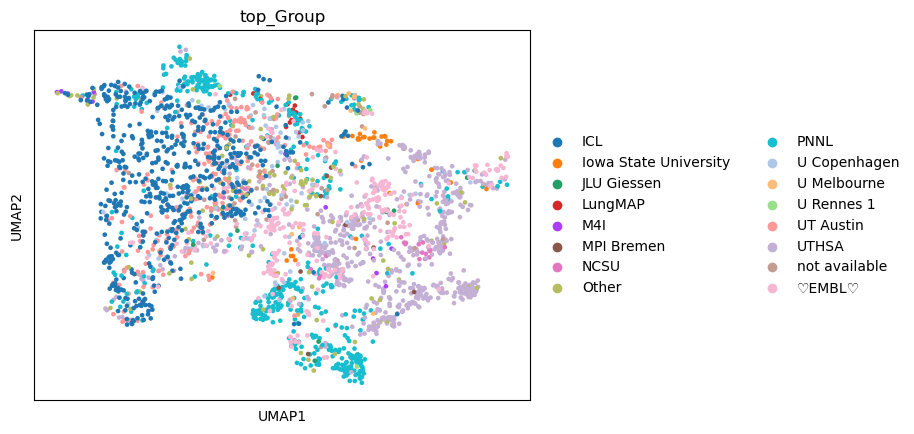

In [53]:
sc.pl.umap(adata_neg_2, color='top_Group')